# Modelling by Merchant Segment
## Forecasting Returning Customer Ratio in Florists

In [16]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt


spark = (
    SparkSession.builder.appName("Florist Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g")  # Increase driver memory
    .config("spark.executor.memory", "16g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()
)

In [3]:
# Read transaction file excluding those marked as fraud
transactions = spark.read.parquet('../data/curated/flagged_fraud')
transactions = transactions.filter(F.col("is_fraud") != True) # Exclude Fraud Transactions

## Filter Transactions by Segment (Florists)
Apply lower-casing.

In [4]:
from pyspark.sql.functions import lower, col

florist_transactions = transactions.filter(lower(col("merchant_category")).contains("florists"))

florist_transactions.show(truncate=False, n=10)


+------------+---------+-------+------------------+------------------------------------+-----------+--------------------------+------------------+--------------------------------+--------------+-----------------+---------------+----------------------+--------------------------+--------------+----------------+-------------+---------------------------------+-----------------+---------------------------+---------------------------+--------+---------------------------------------------+------------+-----------------+
|merchant_abn|year_week|user_id|dollar_value      |order_id                            |consumer_id|fraud_probability_consumer|name_consumer     |address_consumer                |state_consumer|postcode_consumer|gender_consumer|name_merchant         |fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011                    |unemployment_rate|consumer_weekly_transaction|merchant_weekly_transaction|is_fraud|merchant_category                       

## Feature Engineering: Ratio of Returning Customers (Yearly)
* Florists tend to have smaller order values, as indicated by the revenue bands
* Flowers are seasonal
* Thus the heuristic feature of choice would be the ratio of returning customers
* The data is aggregated on a yearly basis to account for the returning customers

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Add a new column for 'order_year' from 'order_datetime'
florist_transactions = florist_transactions.withColumn('order_year', F.year(F.col('order_datetime')))

# Step 2: Calculate total transactions, dollar_value, fraud_probability for each merchant per year
total_transactions_df = florist_transactions.groupBy('merchant_abn', 'order_year').agg(
    F.count("order_id").alias("total_transactions"),
    F.avg("dollar_value").alias("average_dollar_value"),  # Include average dollar value
    F.avg("fraud_probability_merchant").alias("avg_fraud_probability_merchant"),  # Include average fraud prob merchant
    F.avg("fraud_probability_consumer").alias("avg_fraud_probability_consumer"),  # Include average fraud prob consumer,
    F.first("name_merchant").alias("merchant_name"),
    F.first("merchant_category").alias("merchant_category")
)

# Step 3: Calculate repeat customers per merchant per year
repeat_customers_df = florist_transactions.groupBy("merchant_abn", "user_id").agg(
    F.count("order_id").alias("customer_transactions")
).filter(F.col("customer_transactions") > 1) \
 .groupBy("merchant_abn").agg(F.count("user_id").alias("repeat_customers"))

# Step 4: Join the total transactions and repeat customers
yearly_repeat_ratio_df = total_transactions_df.join(repeat_customers_df, on="merchant_abn", how="left")

# Step 5: Fill null values in the 'repeat_customers' column with 0
yearly_repeat_ratio_df = yearly_repeat_ratio_df.withColumn(
    "repeat_customers", F.coalesce(F.col("repeat_customers"), F.lit(0))
)

# Step 6: Calculate the repeat customer ratio for each merchant per year
yearly_repeat_ratio_df = yearly_repeat_ratio_df.withColumn(
    "repeat_customer_ratio", F.col("repeat_customers") / F.col("total_transactions")
)

# Step 7: Create lag features for past repeat customer ratios (previous year)
window_spec = Window.partitionBy('merchant_abn').orderBy('order_year')

# Add lag feature for previous year's repeat customer ratio
yearly_repeat_ratio_df = yearly_repeat_ratio_df.withColumn(
    'previous_repeat_ratio', F.lag('repeat_customer_ratio', 1).over(window_spec)
)

# Fill null values in the lag column with 0 (for the first year)
yearly_repeat_ratio_df = yearly_repeat_ratio_df.fillna({'previous_repeat_ratio': 0})

# Step 8: Add other relevant features (average dollar value, fraud probability)
# These columns are already present in yearly_repeat_ratio_df

# Display the resulting DataFrame
yearly_repeat_ratio_df.show(5)


+------------+----------+------------------+--------------------+------------------------------+------------------------------+--------------------+--------------------+----------------+---------------------+---------------------+
|merchant_abn|order_year|total_transactions|average_dollar_value|avg_fraud_probability_merchant|avg_fraud_probability_consumer|       merchant_name|   merchant_category|repeat_customers|repeat_customer_ratio|previous_repeat_ratio|
+------------+----------+------------------+--------------------+------------------------------+------------------------------+--------------------+--------------------+----------------+---------------------+---------------------+
| 10385163239|      2021|                51|   324.9159337084658|             55.77091422960027|            13.350156006300637|      Sed Et Company|florists supplies...|               0|                  0.0|                  0.0|
| 10385163239|      2022|                 9|   245.5970374443057|           

## Random Forest Regression to Forecast Future Repeat Customer Ratio

In [6]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Feature Engineering
# Select relevant features for modeling
feature_columns = ['total_transactions', 'average_dollar_value', 'avg_fraud_probability_merchant', 
                   'avg_fraud_probability_consumer', 'previous_repeat_ratio']

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Step 4: Random Forest Regressor Setup
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='repeat_customer_ratio')

# Step 5: Create a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

In [7]:
# Step 6: Split Data into Training and Testing Sets
train_data, test_data = yearly_repeat_ratio_df.randomSplit([0.8, 0.2], seed=42)

# Step 7: Train the Random Forest Model
rf_model = pipeline.fit(train_data)

# Step 8: Evaluate Model on Test Data
predictions = rf_model.transform(test_data)

# Evaluate the model's performance using RMSE and R-squared
evaluator = RegressionEvaluator(labelCol="repeat_customer_ratio", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Show some predictions alongside actual values
predictions.select("merchant_abn", "order_year", "repeat_customer_ratio", "prediction").show(5)

24/09/25 23:07:56 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Root Mean Squared Error (RMSE): 0.07254081741377351
R-squared (R²): 0.9322153833762031


+------------+----------+---------------------+--------------------+
|merchant_abn|order_year|repeat_customer_ratio|          prediction|
+------------+----------+---------------------+--------------------+
| 10545955006|      2021|  0.03546099290780142|  0.0748232669129768|
| 12296390138|      2021|  0.16483516483516483| 0.10717922152586216|
| 13108046922|      2021|                  0.0|0.031789818617736526|
| 13401263605|      2022|                  0.0|0.036631809968237304|
| 14796275705|      2022|                  0.0| 0.12898400110037414|
+------------+----------+---------------------+--------------------+
only showing top 5 rows



In [8]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Generate the future projection dataset
# Project future years based on the last available year for each merchant
future_repeat_ratio_df = yearly_repeat_ratio_df.groupBy('merchant_abn').agg(F.max('order_year').alias('latest_year'))

# Generate future year column
num_future_years = 1  # Number of future years to project
future_years = [(year,) for year in range(2023, 2023 + num_future_years)]  # Specify the future years you want to predict
future_years_df = spark.createDataFrame(future_years, ['order_year'])

# Cross-join merchants with future years
future_data = future_repeat_ratio_df.crossJoin(future_years_df)

# Step 2: Join the features from the latest available year for each merchant
latest_data = yearly_repeat_ratio_df.groupBy('merchant_abn').agg(
    F.max('order_year').alias('latest_year'),
    F.first('total_transactions').alias('total_transactions'),
    F.first('average_dollar_value').alias('average_dollar_value'),
    F.first('avg_fraud_probability_merchant').alias('avg_fraud_probability_merchant'),
    F.first('avg_fraud_probability_consumer').alias('avg_fraud_probability_consumer'),
    F.first('previous_repeat_ratio').alias('previous_repeat_ratio'),
    F.first('merchant_name').alias('merchant_name'),
    F.first("merchant_category").alias("merchant_category")
)

# Join the latest available features with the future data
future_data = future_data.join(latest_data, on='merchant_abn', how='left')

# Step 3: Apply the trained model to predict the future repeat customer ratio
future_data = rf_model.transform(future_data)

# Step 4: Show predicted repeat customer ratio for future years
future_data.select('merchant_abn', 'order_year', 'prediction').show(10)


+------------+----------+--------------------+
|merchant_abn|order_year|          prediction|
+------------+----------+--------------------+
| 10385163239|      2023| 0.06169543757548056|
| 10545955006|      2023|  0.0748232669129768|
| 11563852275|      2023| 0.12185909593152675|
| 12296390138|      2023| 0.10717922152586216|
| 13108046922|      2023|0.031789818617736526|
| 13297955415|      2023|0.031789818617736526|
| 13401263605|      2023|0.030137992458465705|
| 13942467372|      2023|0.035753749626281806|
| 14602793938|      2023|0.030718490619134498|
| 14796275705|      2023|0.033793745233018965|
+------------+----------+--------------------+
only showing top 10 rows



In [9]:
future_predictions = future_data.withColumnRenamed('prediction', 'projected_return_cust_ratio')
future_predictions = future_predictions.orderBy(F.col('projected_return_cust_ratio').desc())

In [12]:
future_predictions = future_predictions.select('merchant_abn', 'order_year', 'total_transactions', 'average_dollar_value',
                                               'avg_fraud_probability_merchant', 'avg_fraud_probability_consumer', 'projected_return_cust_ratio','merchant_name','merchant_category')

In [13]:
future_predictions.show(truncate=False, n=10)

+------------+----------+------------------+--------------------+------------------------------+------------------------------+---------------------------+------------------------------+---------------------------------------------+
|merchant_abn|order_year|total_transactions|average_dollar_value|avg_fraud_probability_merchant|avg_fraud_probability_consumer|projected_return_cust_ratio|merchant_name                 |merchant_category                            |
+------------+----------+------------------+--------------------+------------------------------+------------------------------+---------------------------+------------------------------+---------------------------------------------+
|21772962346 |2023      |23829             |134.64395525980592  |29.131465404078885            |12.871646625372854            |0.23211881333906453        |Purus Gravida Sagittis Ltd    |florists supplies, nursery stock, and flowers|
|80682333501 |2023      |20609             |14.98234220653276   |32.

## Export Ranking and Relevant Columns

In [14]:
future_predictions = future_predictions.select('merchant_abn', 'merchant_name', 'merchant_category', 'order_year', 'projected_return_cust_ratio')

In [12]:
#future_predictions.write.parquet('../data/curated/florists_ranking')

24/09/25 19:54:24 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 881112 ms exceeds timeout 120000 ms
24/09/25 19:54:24 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/25 19:54:30 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

## Model Evaluation

In [15]:
rf_stage = rf_model.stages[-1] 
importances = rf_stage.featureImportances
importance_values = importances.toArray()
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importance_values
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [18]:
importance_values

array([0.16991266, 0.05334434, 0.06565906, 0.0612155 , 0.64986844])

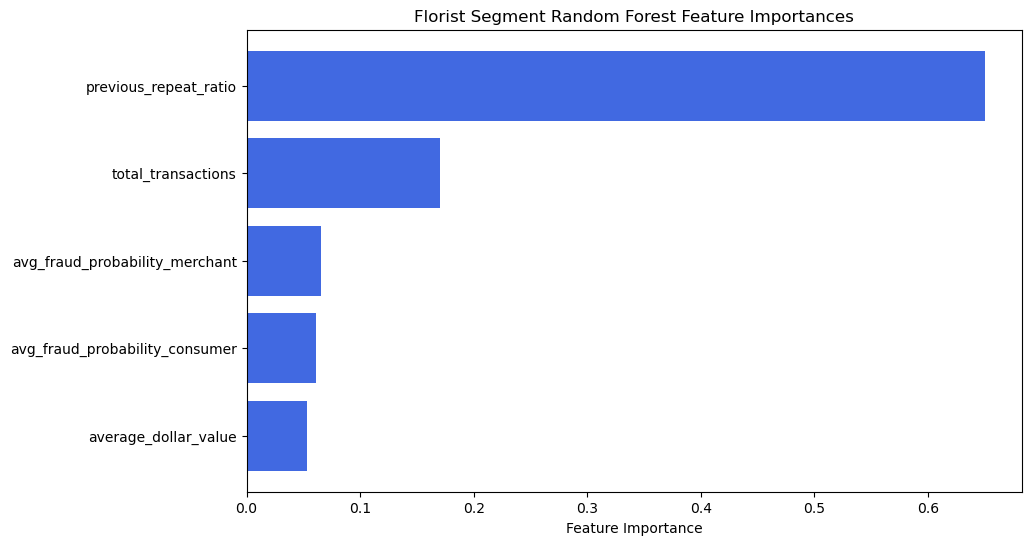

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.title('Florist Segment Random Forest Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()